In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlb
import seaborn as sns
import os
from glob import glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.stats import wilcoxon
import itertools

sns.set_style("white")
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 300

def compute_pval(df_data, mstr, group='Method', metric='Value'):
    mmt_vals = [
        obj[metric] 
        for obj in df_data.query('Method == "MMT"').groupby('Case').mean().to_dict(orient='records')
    ]
    milr_vals = [
        obj[metric] 
        for obj in df_data.query('Method == "MILR"').groupby('Case').mean().to_dict(orient='records')
    ]
    mmgan_vals = [
        obj[metric] 
        for obj in df_data.query('Method == "MMGAN"').groupby('Case').mean().to_dict(orient='records')
    ]
    
    alt = 'less' if mstr == 'LPIPS' else 'greater'
    
    _, milr_pval = wilcoxon(mmt_vals, milr_vals, alternative=alt)
    _, mmgan_pval = wilcoxon(mmt_vals, mmgan_vals, alternative=alt)
    
    return milr_pval, mmgan_pval

def barplot_metric(df_metrics, metric, dataset, model, contrast=None, 
                   bpath='/home/srivathsa/projects/mmt_figs', mval=1):
    query = 'Metric == "{}" and Dataset == "{}" and Model == "{}" and M == {}'.format(metric, dataset, model, mval)
    colors = ['#8DA0CB', '#F88D62', '#66C2A5']
    colors = colors[::-1]
    
    if contrast is not None:
        query += ' and Contrast == "{}"'.format(contrast)
    
    print(query)
    df_data = df_metrics.query(query)

    means = [obj['Value'] for obj in df_data.groupby("Method").mean().to_dict(orient='records')][::-1]
    stds = [obj['Value'] for obj in df_data.groupby("Method").std().to_dict(orient='records')][::-1]
    pvals = compute_pval(df_data, metric)[::-1]
    ax = sns.barplot(y='Method', x='Value', data=df_data, order=methods[::-1], ci=None, orient='h', 
                 errwidth=1.5, capsize=0.1, dodge=False, 
                 edgecolor='k', linewidth=1.5)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    nh = 0.4

    y_vals = [0.4, 0.8, 1.2]

    ax.set_ylim(0, 2)
    xlim = ax.get_xlim()[1] * 1.5
    ax.set_xlim(0, xlim)
    inc_unit = lambda x: (x * xlim) / 100

    for i, bar in enumerate(ax.patches):
        y = bar.get_y()
        h = bar.get_height()

        c = y + h/2.
        new_y = c-nh/2.
        bar.set_y(y_vals[i])
        bar.set_height(nh)
        bar.set_facecolor(colors[i])

#         ax.errorbar(means[i], y_vals[i]+0.2, xerr=stds[i], ecolor='k', lw=1.5, capsize=5, capthick=1.5)
        ax.text(inc_unit(2), y_vals[i]+0.15, '{:.3f} ± {:.3f}'.format(means[i], stds[i]), 
                fontdict=dict(fontsize=18, color='k', weight='bold'))

    max_h = max([m for m, s in zip(means, stds)])

    if pvals[0] < 0.05:
        x1 = max_h + inc_unit(1)
        x2 = max_h + inc_unit(2.5)
        y1 = y_vals[2] - 0.2
        y2 = y_vals[1] - 0.2

        ax.plot([x1, x2], [y1, y1], color='k')
        ax.plot([x1, x2], [y2, y2], color='k')
        ax.plot([x2, x2], [y2, y1], color='k')

        s1 = '**' if pvals[0] < 0.005 else '*'
        ax.text(x2 + inc_unit(0.78), ((y1 + y2)/2.0) - 0.1, s1, fontdict=dict(fontsize=20))

    if pvals[1] < 0.05:
        x3 = max_h + inc_unit(6.5)
        x4 = max_h + inc_unit(8)
        y3 = y_vals[2] + 0.2
        y4 = y_vals[0] + 0.2

        ax.plot([x3, x4], [y3, y3], color='k')
        ax.plot([x3, x4], [y4, y4], color='k')
        ax.plot([x4, x4], [y4, y3], color='k')

        s2 = '**' if pvals[1] < 0.005 else '*'
        ax.text(x4 + inc_unit(0.78), ((y3+y4)/2.0) - 0.1, s2, fontdict=dict(fontsize=20))
    plt.box(False)
    
    print('pval 1', pvals[0], 'pval 2', pvals[1])
    fname = '{}_{}_{}'.format(dataset.lower(), model.lower(), metric.lower())
    if model != 'single':
        fname = '{}_m{}'.format(fname, mval)
    if contrast is not None:
        fname += '_{}'.format(contrast)
    fname = '{}.png'.format(fname)
    fpath = os.path.join(bpath, fname)
    print('Writing to {}...'.format(fpath))
    plt.tight_layout()
    plt.savefig(fpath, dpi=350, pad_inches=0.1)
    plt.clf()
    
def get_binary_combs(l=4):
    combs = [['0', '1']] * l
    dsum = lambda d: np.sum(np.array(list(d), dtype=int))
    return [''.join(p) for p in itertools.product(*combs) if dsum(p) > 0 and dsum(p) < l]

def format_metric_str(metric_val_dict):
    mvals = ['{:.3f}'.format(metric_val_dict[m]) for m in metrics]
    return '/'.join(mvals)

In [36]:
bin_combs = get_binary_combs(l=4)
dset = 'BRATS'
method = 'MMT'

df_data = df_metrics.query('Dataset == "{}" and Method == "{}" and Model == "{}"'.format(dset, method, 'random'))

for bcomb in bin_combs:
    df_comb = df_data.query('Filename == "{}"'.format(bcomb))
    row_strs = []
    for cstr in cons[dset]:
        df_met = df_comb.query('Contrast == "{}"'.format(cstr))
        vals = df_met.groupby('Metric').mean().to_dict()['Value']
        if vals:
            row_strs.append(format_metric_str(vals))
        else:
            row_strs.append('-')
    
    disp_str = ['yes' if b == '1' else 'no' for b in bcomb] + row_strs
    print(','.join(disp_str))

NameError: name 'df_metrics' is not defined

In [37]:
datasets = ['IXI', 'BRATS']
methods = ['MILR', 'MMGAN', 'MMT']
models = ['single', 'random']
cons = {
    'IXI': ['T1', 'T2', 'PD'],
    'BRATS': ['T1', 'T1Gd', 'T2', 'FLAIR']
}
metrics = ['PSNR', 'SSIM', 'LPIPS']

base_path = '/home/srivathsa/projects/studies/gad/mmt_seg/quant'
sum_chk = lambda fpath: np.sum([1-int(c) for c in list(fpath.split('/')[-1].replace('.xlsx', ''))])

fpath_xls = [f for f in glob('{}/**/*.xlsx'.format(base_path), recursive=True)]
all_metrics = []

for fp in tqdm(fpath_xls, total=len(fpath_xls)):
    df_metrics = pd.read_excel(fp, sheet_name=None)
    
    con_strs = [c for c in df_metrics.keys() if c != 'Sheet']
    
    for con_str in con_strs:
        dict_vals = df_metrics[con_str].to_dict(orient='records')
        
        for drow in dict_vals:
            for metric in metrics:
                metric_val = drow[metric]

                mobj = {
                    'Metric': metric,
                    'Contrast': con_str,
                    'Model': fp.split('/')[-3],
                    'Dataset': fp.split('/')[-4],
                    'Method': fp.split('/')[-2],
                    'M': sum_chk(fp),
                    'Value': metric_val,
                    'Case': drow['Filename'].split('/')[0],
                    'Slice': int(drow['Filename'].split('/')[1].replace('.npy', '')),
                    'Filename': fp.split('/')[-1].replace('.xlsx', '')
                }
                all_metrics.append(mobj)

<ipython-input-37-c0cf47593e27>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fp in tqdm(fpath_xls, total=len(fpath_xls)):


  0%|          | 0/81 [00:00<?, ?it/s]

In [38]:
df_metrics = pd.DataFrame(all_metrics)

In [ ]:
df_metrics.query('Metric == "PSNR" and Contrast == "T1" and Model == "random" and Dataset == "BRATS" and Method == "MILR" and Case == "BraTS2021_00111" and Slice == 50 and Filename == "0010" and M==3')

In [ ]:
df_data = pd.read_excel('/home/srivathsa/projects/studies/gad/mmt_seg/quant/BRATS/random/MMT/0111.xlsx', 
                        sheet_name=None)
df_data

In [91]:
# for ds in datasets:
#     for model in models:
#         for metric in metrics:
#             if model == 'single':
#                 print('====', ds, model, metric, 'm=1')
#                 barplot_metric(df_metrics, metric=metric, dataset=ds, model=model, 
#                                mval=1, bpath='/home/srivathsa/projects/mmt_figs')
#             else:
#                 for mval in np.arange(1, len(cons[ds])):
#                     print('====', ds, model, metric, 'm={}'.format(mval))
#                     barplot_metric(df_metrics, metric=metric, dataset=ds, model=model, 
#                                mval=mval, bpath='/home/srivathsa/projects/mmt_figs')
                
barplot_metric(df_metrics, metric='PSNR', dataset='IXI', model='random', 
               mval=2, bpath='/home/srivathsa/projects/mmt_figs')

Metric == "PSNR" and Dataset == "IXI" and Model == "random" and M == 2


ValueError: Invalid RGBA argument: ['#8DA0CB', '#F88D62', '#66C2A5']

In [103]:
import imageio

for fpath_png in glob('/home/srivathsa/projects/mmt_figs/*.png'):
    img = imageio.imread(fpath_png)
    img = img[370:1380, 40:2110]
    imageio.imsave(fpath_png, img)

### Tumor Segmentation

In [78]:
dirpath_metrics = '/home/srivathsa/projects/studies/gad/mmt_seg/seg'

all_dice = []
csv_files = [f for f in glob('{}/metrics_*/*.csv'.format(dirpath_metrics))]
for fpath_csv in tqdm(csv_files, total=len(csv_files)):
    method = fpath_csv.split('/')[-2].split('_')[-1].upper()
    contrast = fpath_csv.split('/')[-1].replace('_syn.csv', '')
    
    df_data = pd.read_csv(fpath_csv)
    
    for metric_row in df_data.to_dict(orient='records'):
        mobj = {
            'Case': metric_row['Case'],
            'Value': np.mean([metric_row['ET'], metric_row['TC'], metric_row['WT']]),
            'Method': method,
            'Contrast': contrast,
            'Model': 'single',
            'Dataset': 'BRATS',
            'Metric': 'DICE',
            'M': 1
        }
        all_dice.append(mobj)

df_dice = pd.DataFrame(all_dice)
df_dice

<ipython-input-78-35c9d7e0586c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fpath_csv in tqdm(csv_files, total=len(csv_files)):


  0%|          | 0/12 [00:00<?, ?it/s]

,Case,Value,Method,Contrast,Model,Dataset,Metric,M
0,BraTS2021_00111,0.694892,MMT,T1Gd,single,BRATS,DICE,1
1,BraTS2021_00117,0.551960,MMT,T1Gd,single,BRATS,DICE,1
2,BraTS2021_00137,0.842868,MMT,T1Gd,single,BRATS,DICE,1
3,BraTS2021_00140,0.435699,MMT,T1Gd,single,BRATS,DICE,1
4,BraTS2021_00177,0.918955,MMT,T1Gd,single,BRATS,DICE,1
...,...,...,...,...,...,...,...,...
751,BraTS2021_01550,0.960524,MILR,FLAIR,single,BRATS,DICE,1
752,BraTS2021_01558,0.665291,MILR,FLAIR,single,BRATS,DICE,1
753,BraTS2021_01592,0.927138,MILR,FLAIR,single,BRATS,DICE,1
754,BraTS2021_01649,0.868191,MILR,FLAIR,single,BRATS,DICE,1


In [102]:
for con in cons['BRATS']:
    barplot_metric(df_dice, metric='DICE', dataset='BRATS', model='single', contrast=con,
                   mval=1, bpath='/home/srivathsa/projects/mmt_figs')

Metric == "DICE" and Dataset == "BRATS" and Model == "single" and M == 1 and Contrast == "T1"
pval 1 8.435659527084613e-11 pval 2 6.66917349824795e-05
Writing to /home/srivathsa/projects/mmt_figs/brats_single_dice_T1.png...
Metric == "DICE" and Dataset == "BRATS" and Model == "single" and M == 1 and Contrast == "T1Gd"
pval 1 7.374296604127792e-11 pval 2 0.07333786313548717
Writing to /home/srivathsa/projects/mmt_figs/brats_single_dice_T1Gd.png...
Metric == "DICE" and Dataset == "BRATS" and Model == "single" and M == 1 and Contrast == "T2"
pval 1 2.58419740681613e-12 pval 2 0.0006940102982226807
Writing to /home/srivathsa/projects/mmt_figs/brats_single_dice_T2.png...
Metric == "DICE" and Dataset == "BRATS" and Model == "single" and M == 1 and Contrast == "FLAIR"
pval 1 1.0255692185770687e-11 pval 2 1.2538994817819324e-08
Writing to /home/srivathsa/projects/mmt_figs/brats_single_dice_FLAIR.png...


<Figure size 2400x1500 with 0 Axes>

In [ ]:
df_grp = df_metrics.drop('Slice', axis=1).groupby(by=['Dataset', 'Model', 'M', 'Method', 'Metric']).agg(['mean', 'std'])

In [ ]:
dict_grp = df_grp.to_dict(orient='split')
grp_indices = dict_grp['index']
grp_vals = dict_grp['data']

In [ ]:
for mth in metrics:
    i = grp_indices.index(('BRATS', 'random', 3, 'MMT', mth))
    print(mth, grp_vals[i])

### Attention Percentage

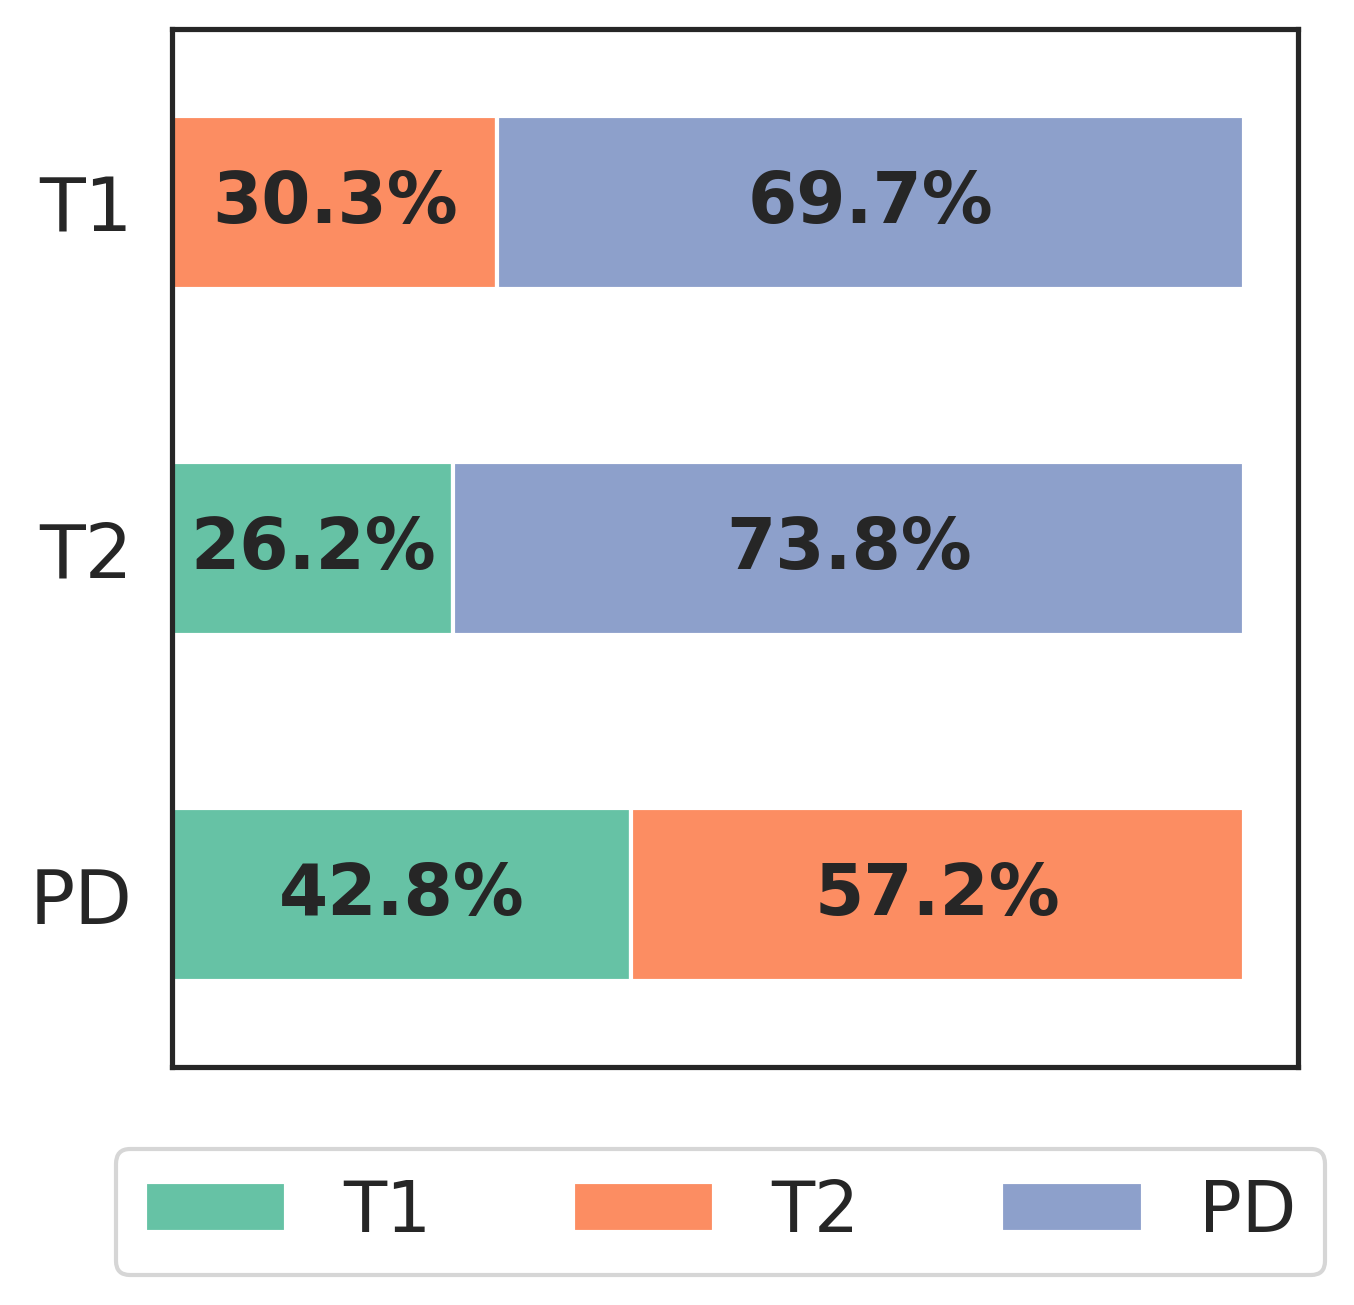

In [73]:
df = pd.read_excel("/home/srivathsa/projects/mmt_figs/attn_ixi.xlsx")
sns.set()
sns.set_style("white")
sns.set_palette('Set2')

df.plot(
    x = 'Output',
    y = ['T1', 'T2', 'PD'],
    kind = 'barh',
    stacked = True,
    #title = 'IXI',
    mark_right = True,
    figsize=(4.75, 4.5))

df_total = df["T1"] + df["T2"] + df["PD"]
df_rel = df[df.columns[1:]].div(df_total, 0)*100


for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                         df[n], df_rel[n])):
        if pc > 0:
            plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                     va = 'center', ha = 'center',fontsize=17, weight='bold')
legend_outside = plt.legend(loc=(-0.05, -0.2), ncol=len(df.columns), fontsize=17)
plt.ylabel('')
plt.gca().invert_yaxis()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig("/home/srivathsa/projects/mmt_figs/attn_ixi.png",bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight',dpi=350)

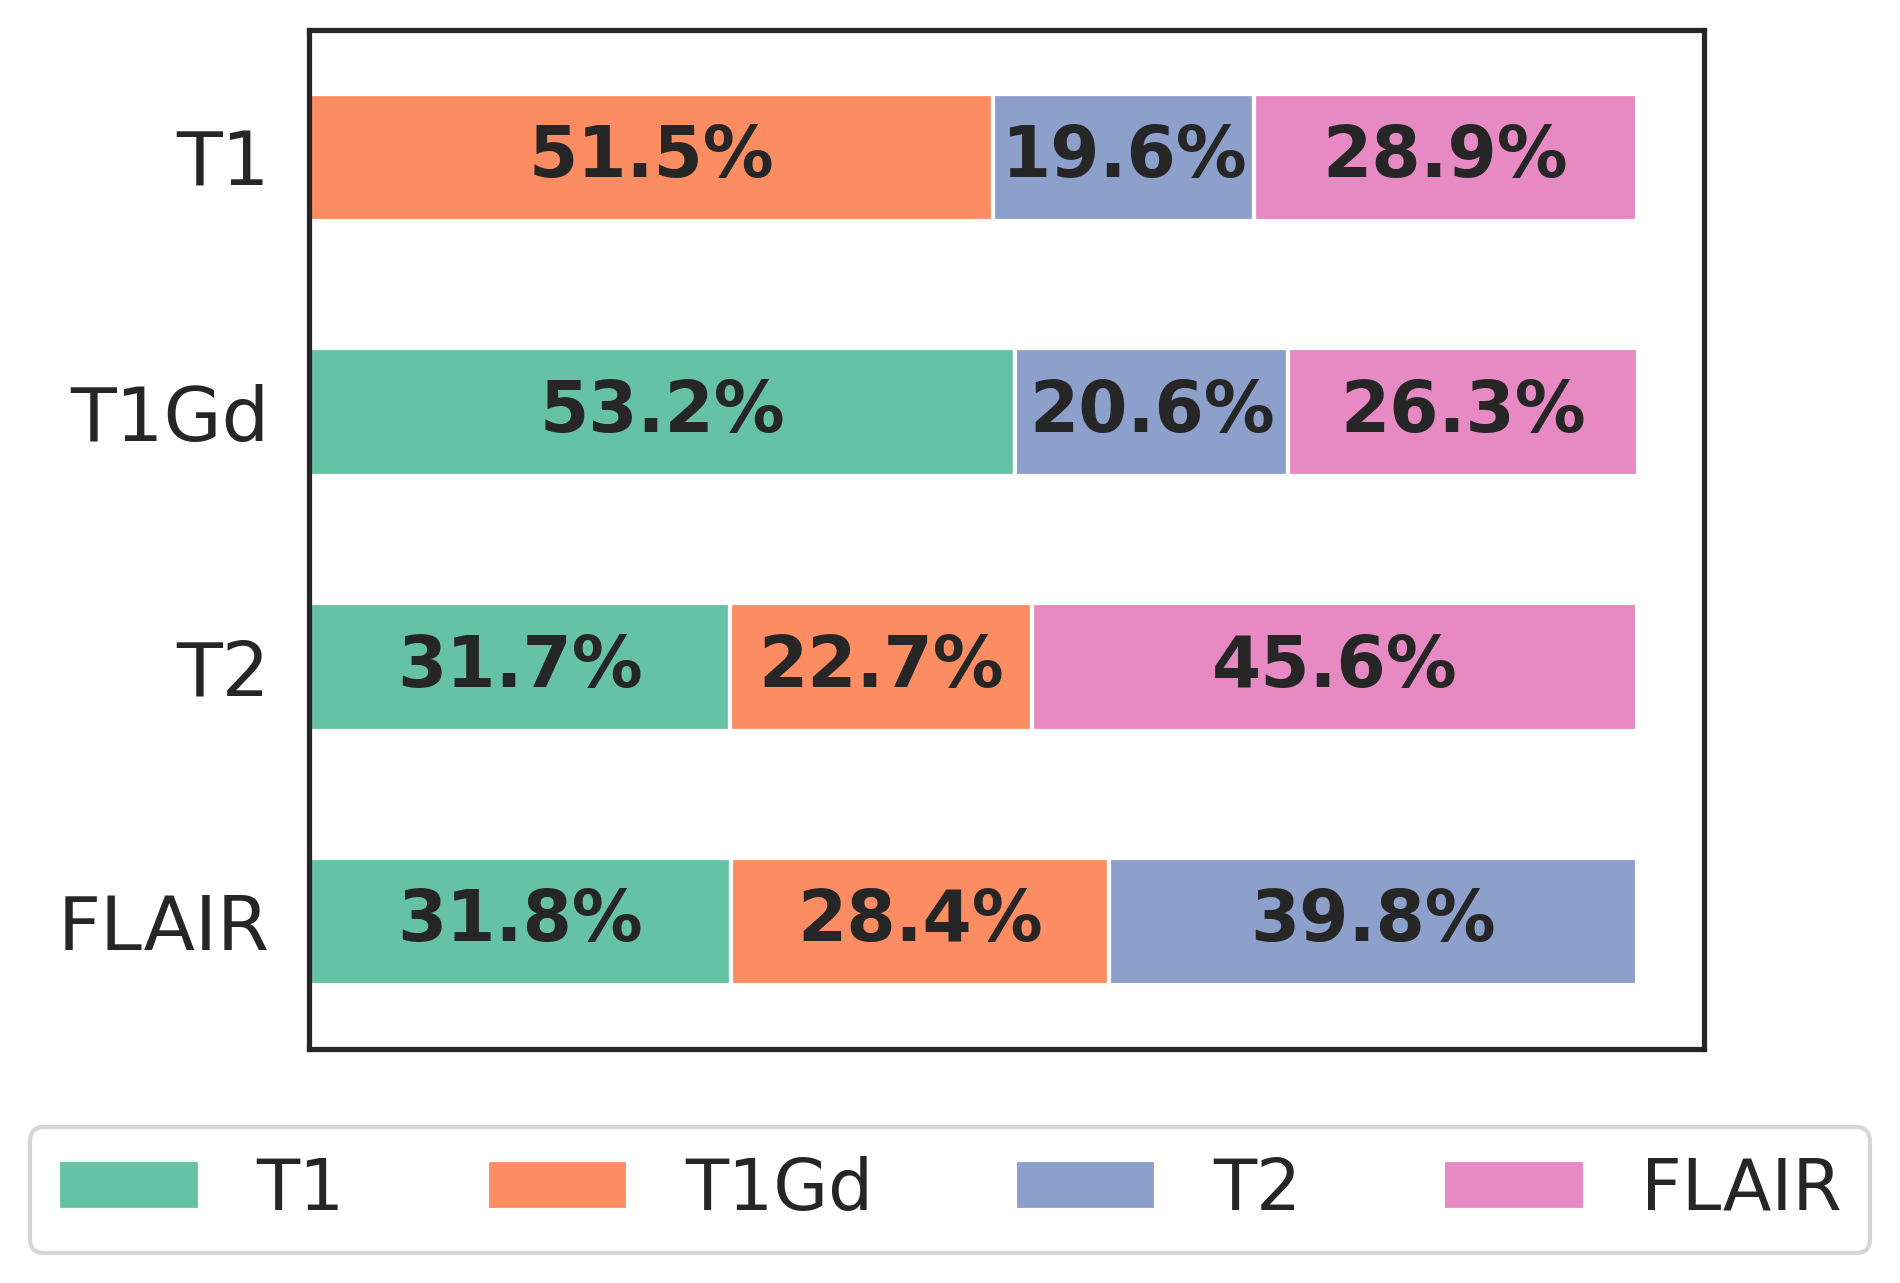

In [77]:
df = pd.read_excel("/home/srivathsa/projects/mmt_figs/attn_brats.xlsx")
sns.set()
sns.set_style("white")
sns.set_palette('Set2')

df.plot(
    x = 'Output',
    y = ['T1', 'T1Gd', 'T2', 'FLAIR'],
    kind = 'barh',
    stacked = True,
    #title = 'BraTS', #percentage of attention scores
    mark_right = True,
    figsize=(6, 4.5))
legend_outside = plt.legend(loc=(-0.2, -0.2), ncol=len(df.columns), fontsize=17)
df_total = df["T1"] + df["T1Gd"] + df["T2"] + df["FLAIR"]
df_rel = df[df.columns[1:]].div(df_total, 0)*100
  
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                         df[n], df_rel[n])):
        if pc > 0:
            plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                     va = 'center', ha = 'center', fontsize=17, weight='bold')
plt.ylabel('')
plt.gca().invert_yaxis()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(axis='y', labelsize=18)
plt.savefig("/home/srivathsa/projects/mmt_figs/attn_brats.png",bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight', dpi=350)

In [24]:
df

,Output,T1,T2,PD
0,T1,0.0000,0.3028,0.6972
1,T2,0.2619,0.0000,0.7381
2,PD,0.4278,0.5722,0.0000
